# AMC comments scraped from wsb

## Data Cleaning

In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from pmaw import PushshiftAPI
import matplotlib.pyplot as plt
import math
from datetime import datetime
import datetime as dt
from nltk.tokenize import RegexpTokenizer, TweetTokenizer, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.metrics import plot_confusion_matrix
import re
import string
import seaborn as sns
from wordcloud import WordCloud
pd.set_option('display.max_colwidth', -1)

<ipython-input-1-25681cb85bc3>:25: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [2]:
amc = pd.read_csv('data/amc_comments.csv', low_memory=False)

In [3]:
relevant_columns=['body','score','total_awards_received','created_utc','author','permalink']

In [4]:
amc = amc[relevant_columns]
amc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 6 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   body                   100000 non-null  object
 1   score                  100000 non-null  int64 
 2   total_awards_received  100000 non-null  int64 
 3   created_utc            100000 non-null  int64 
 4   author                 100000 non-null  object
 5   permalink              100000 non-null  object
dtypes: int64(3), object(3)
memory usage: 4.6+ MB


## EDA

In [5]:
def unix_to_date(input):
    ts = int(input)
    print(datetime.utcfromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S'))

In [6]:
unix_to_date(1612357333)

2021-02-03 13:02:13


In [7]:
unix_to_date(1628237951)

2021-08-06 08:19:11


In [8]:
#lowest score post from 8/6/21:
amc.iloc[71057]

body                     The real WSB ain’t never coming back. Know why? The AMC dick lickers ruined it for everyone. Who remembers those fucking days where it was just fucking straight yolos for no reason? It’s gut wrenching that the amc boys with the glowing eyes on Twitter &amp; the YouTube movement ran this shit to the ground (kinda).
score                    -164                                                                                                                                                                                                                                                                                                                       
total_awards_received    0                                                                                                                                                                                                                                                                                                    

In [9]:
#Top score and top awarded post from 2/3/21: 
amc.iloc[73992]

body                     At this point, GME, AMC et al. are trading with the type of volatility weekly options usually do. Seasoned WSB people freaking out: come on, you're better than this. How many times have you been down 90% on a trade and just said fuck it may as well let it go to 0, something crazy could happen. And if you've been irresponsibly trading options long enough, you know - sometimes it does, and your -90% position goes to +200% in minutes based on a tweet from Trump or Elon or some other random factor. Well get it through your head that these are fucking SHARES. They don't expire, there's no theta decay, and they don't require a perfectly timed miracle to regain value. Remember when shares around here were boring and for pussies and people were openly mocked for even buying them when they could have bought options? Calm your tits and act like the degenerate gamblers you are instead of flipping out because you're losing money on a trade. THAT'S NORMAL HERE REMEMBER??\n\

In [10]:
#locked post? Only 1 in 100k
# amc.loc[amc.locked == True, :]
# amc.iloc[27784]['body']

In [11]:
# amc.loc[amc['total_awards_received']==46,:]['body']

In [12]:
# amc.head()

In [13]:
def wordcloud_maker(df, feature):
    wordcloud = WordCloud(width = 1000,
                       height = 800,
                       colormap = 'viridis', 
                       margin = 0,
                       max_words = 200,  
                       min_word_length = 4,
                       max_font_size = 120, min_font_size = 15,  
                       background_color = "black").generate(" ".join(df[feature]))
    plt.figure(figsize = (10, 15))
    plt.imshow(wordcloud)
    plt.title(f'{feature} Wordcloud', fontsize=32, fontweight='bold')
    plt.axis('off')

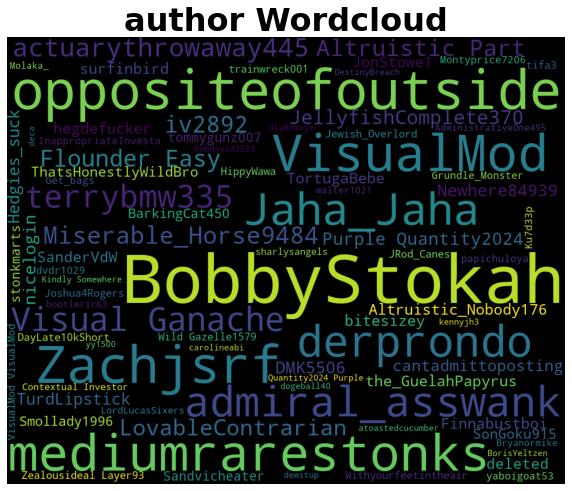

In [14]:
wordcloud_maker(amc, 'author')

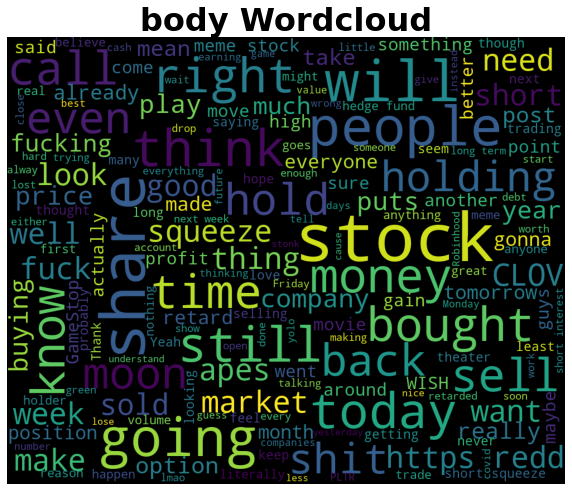

In [15]:
wordcloud_maker(amc, 'body')

In [16]:
def body_cleaner(comment):
    body_stopwords = ['https','redd','amp']
    punctuation = set(string.punctuation)
    punctuation.remove('#')    
    x = comment
    x = re.sub(r'https?:\/\/\S+', '', x) #remove URLs
    x = re.sub(r'{link}', '', x) #placeholders
    x = re.sub(r'@[\w]*', '', x) #@mention users
#     x = re.sub('[^A-Za-z0-9]+', ' ', x) #@mention users
    x = re.sub(r'&[a-z]+;', '', x) #remove HTML ref chars
#     x = re.sub(r'@[^\s]+','',x) #cleaner conds 2
#     x = re.sub(r"http\S+", "", x)
#     x = ' '.join(re.findall(r'\w+', x))
#     x = re.sub(r'\s+[a-zA-Z]\s+', '', x)
#     x = re.sub(r'\s+', ' ', x, flags=re.I)
    x = ''.join(ch for ch in x if ch not in punctuation) #remove punctuation
    x = x.replace("[^a-zA-z]#", " ") #remove special chars
    x = [word.lower() for word in x.split() if word.lower() not in body_stopwords] #lowercase
    
    return ' '.join(x)

In [17]:
amc['cleaned_body'] = amc['body'].map(lambda x: body_cleaner(x))

In [18]:
amc['cleaned_body']

0        same i love movies and some movies really have to be seen in the theater to really appreciate them when this is all over im definitely hitting up amc to watch some flicks with a beer and tendies                                                                                                                                                                                                                                                                      
1        i have a question for anyone that has the answer to this are the hedgefunds that shorted gme the same hedgefunds that shorted amc why are these two so similar in price action                                                                                                                                                                                                                                                                                          
2        hey guys on a scale of 110 how retarded am i i bought 7 put

In [19]:
amc.head()

,body,score,total_awards_received,created_utc,author,permalink,cleaned_body
0,"Same. I love movies, and some movies really have to be seen in the theater to really appreciate them. When this is all over, I'm definitely hitting up AMC to watch some flicks with a beer and tendies.",3,0,1614904519,runningraleigh,/r/wallstreetbets/comments/lxt5g7/holding_holding_holding_i_keep_holding_on/gppw1mi/,same i love movies and some movies really have to be seen in the theater to really appreciate them when this is all over im definitely hitting up amc to watch some flicks with a beer and tendies
1,I have a question for anyone that has the answer to this; are the hedgefunds that shorted GME the same hedgefunds that shorted AMC? Why are these two so similar in price action?,1,0,1614904484,BigTowFuzz,/r/wallstreetbets/comments/lxwhpy/gme_possibility_of_gamma_squeeze_just_went/gppvz4s/,i have a question for anyone that has the answer to this are the hedgefunds that shorted gme the same hedgefunds that shorted amc why are these two so similar in price action
2,"Hey guys, on a scale of 1-10 how retarded am I. I bought $7 puts on AMC while it was tanking while 50% of everything I've earned is in it @ $9",3,0,1614904447,Spid-CR,/r/wallstreetbets/comments/lxva6s/what_are_your_moves_tomorrow_march_05_2021/gppvwlk/,hey guys on a scale of 110 how retarded am i i bought 7 puts on amc while it was tanking while 50 of everything ive earned is in it 9
3,Got 50 AMC at 13.30 and 52 GME at 111. Don’t forget me on the way,14,0,1614904423,OleJohny3Balls,/r/wallstreetbets/comments/lxt5mx/gme_and_amc_holders_right_now/gppvuy7/,got 50 amc at 1330 and 52 gme at 111 don’t forget me on the way
4,Truly fuck AMC.,2,0,1614904404,sawdos,/r/wallstreetbets/comments/lxt5mx/gme_and_amc_holders_right_now/gppvtls/,truly fuck amc


In [20]:
sia = SentimentIntensityAnalyzer()
def find_sentiment(post):
    if sia.polarity_scores(post)["compound"] > 0:
        return "Positive"
    elif sia.polarity_scores(post)["compound"] < 0:
        return "Negative"
    else:
        return "Neutral" 

In [21]:
# def plot_sentiment(df, feature, title):
#     counts = df[feature].value_counts()
#     fig, ax = plt.subplots(figsize=(8, 8))
#     counts.plot(kind='bar', ax=ax, color='green')
#     ax.set_ylabel('Count', size=24)
#     plt.title(f"Sentiment Analysis: {title}", fontsize=32, fontweight='bold')
#     plt.tight_layout()
#     plt.tick_params(labelsize=20)
#     plt.xticks(rotation=30)
#     plt.show()

In [22]:
amc['body_sentiment'] = amc['cleaned_body'].apply(lambda x: find_sentiment(x))

In [23]:
# plot_sentiment(amc, 'body_sentiment', 'Body')

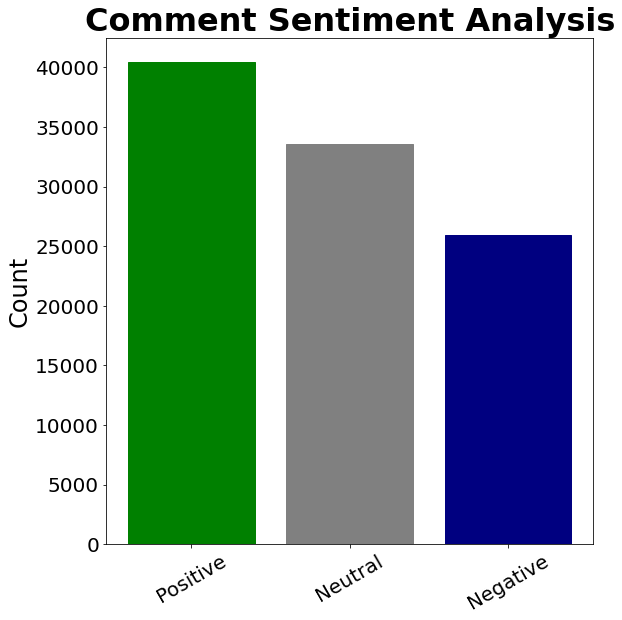

In [24]:
counts = amc['body_sentiment'].value_counts()
fig, ax = plt.subplots(figsize=(8, 8))
barlist = plt.bar(['Positive','Neutral','Negative'],counts)
barlist[0].set_color('green')
barlist[1].set_color('grey')
barlist[2].set_color('navy')
ax.set_ylabel('Count', size=24)
plt.title("Comment Sentiment Analysis", fontsize=32, fontweight='bold')
plt.tight_layout()
plt.tick_params(labelsize=20)
plt.xticks(rotation=30)
plt.show()

In [25]:
amc['body_sentiment'].value_counts()

Positive    40458
Neutral     33606
Negative    25936
Name: body_sentiment, dtype: int64

In [26]:
# amc.to_csv('./amc_modeling.csv', index=False)

In [27]:
stopwords_list = stopwords.words('english')
stopwords_list.append('amc')
stopwords_list.append('gme')
pattern = r"(?u)\w{3,}"
tokenizer = RegexpTokenizer(pattern)
stemmer = PorterStemmer()
def preprocess_text(text, tokenizer, stopwords_list, stemmer):
    text_tokens = tokenizer.tokenize(text)
    text_tokens_stopped = [word for word in text_tokens if word not in stopwords_list]
    final_text = [stemmer.stem(token) for token in text_tokens_stopped]
    return final_text

In [28]:
preprocessed_text = amc.cleaned_body.apply(lambda x: preprocess_text(x, tokenizer, stopwords_list, stemmer))

In [29]:
amc['preprocessed'] = preprocessed_text

In [30]:
# amc.head()

In [31]:
amc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   body                   100000 non-null  object
 1   score                  100000 non-null  int64 
 2   total_awards_received  100000 non-null  int64 
 3   created_utc            100000 non-null  int64 
 4   author                 100000 non-null  object
 5   permalink              100000 non-null  object
 6   cleaned_body           100000 non-null  object
 7   body_sentiment         100000 non-null  object
 8   preprocessed           100000 non-null  object
dtypes: int64(3), object(6)
memory usage: 6.9+ MB


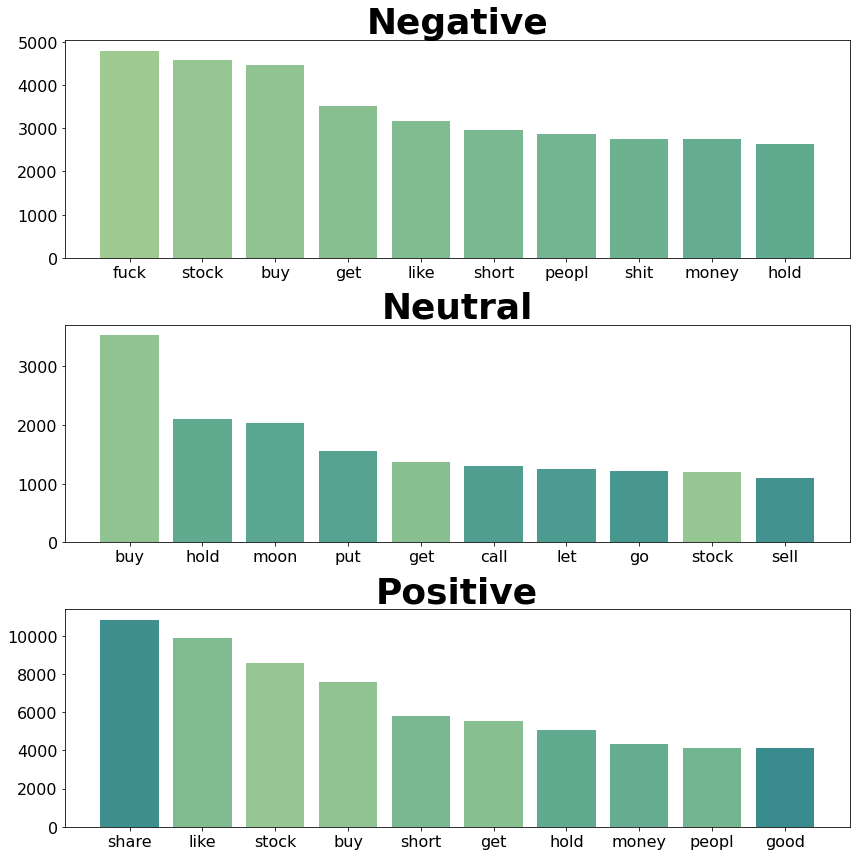

In [32]:
fig, axes = plt.subplots(nrows=3, figsize=(12, 12))
plotted_words_and_colors = {}
color_palette = sns.color_palette('crest', n_colors=38)
data_by_sent = [y for _, y in amc.groupby('body_sentiment', as_index=False)]
for idx, sent_df in enumerate(data_by_sent):
    all_words_in_genre = sent_df.preprocessed.explode()
    top_10 = all_words_in_genre.value_counts()[:10]
    colors = []
    for word in top_10.index:
        if word not in plotted_words_and_colors:
            new_color = color_palette.pop(0)
            plotted_words_and_colors[word] = new_color
        colors.append(plotted_words_and_colors[word])
    ax = axes[idx]
    ax.bar(top_10.index, top_10.values, color=colors)
    ax.set_title(sent_df.iloc[0].body_sentiment.title(), fontsize=36, fontweight='bold')
    ax.tick_params(labelsize=16)
    
fig.tight_layout()

In [33]:
body_data = amc[['body']].copy()
body_data = body_data.dropna()
body_data.body =body_data.body.str.lower()
body_data.body   = body_data.body.apply(lambda x:re.sub('@[^\s]+','',x))
body_data.body   = body_data.body.apply(lambda x:re.sub(r"http\S+", "", x))
body_data.body   = body_data.body.apply(lambda x:' '.join(re.findall(r'\w+', x)))
body_data.body   = body_data.body.apply(lambda x:re.sub(r'\s+[a-zA-Z]\s+', '', x))
body_data.body   = body_data.body.apply(lambda x:re.sub(r'\s+', ' ', x, flags=re.I))
body_data['sentiments']           = body_data['body'].apply(lambda x: sia.polarity_scores(' '.join(re.findall(r'\w+',x.lower()))))
body_data['Positive Sentiment']   = body_data['sentiments'].apply(lambda x: x['pos']+1*(10**-6)) 
body_data['Neutral Sentiment']    = body_data['sentiments'].apply(lambda x: x['neu']+1*(10**-6))
body_data['Negative Sentiment']   = body_data['sentiments'].apply(lambda x: x['neg']+1*(10**-6))
body_data.drop(columns=['sentiments'],inplace=True)

In [34]:
body_data

,body,Positive Sentiment,Neutral Sentiment,Negative Sentiment
0,samelove movies and some movies really have to be seen in the theater to really appreciate them when this is all overm definitely hitting up amc to watch some flicks withbeer and tendies,0.155001,0.845001,0.000001
1,i havequestion for anyone that has the answer to this are the hedgefunds that shorted gme the same hedgefunds that shorted amc why are these two so similar in price action,0.000001,1.000001,0.000001
2,hey guys onscale of 1 10 how retarded ami bought 7 puts on amc while it was tanking while 50 of everythingve earned is in it 9,0.000001,0.861001,0.139001
3,got 50 amc at 13 30 and 52 gme at 111 donforget me on the way,0.000001,1.000001,0.000001
4,truly fuck amc,0.392001,0.135001,0.473001
...,...,...,...,...
99995,funny how amc hasnreally dumped yetremember when it was about 2 less than 6 months ago wherethe dump part of the pump and dump,0.101001,0.625001,0.274001
99996,amc and gme only fuck off shill,0.000001,0.632001,0.368001
99997,not to late to jump onboard the amc rocket get in while you can,0.000001,1.000001,0.000001
99998,clne taco amc wkhs uwmc,0.000001,1.000001,0.000001


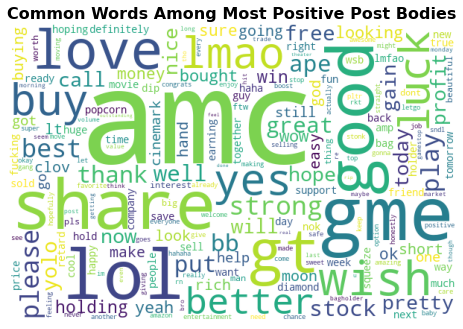

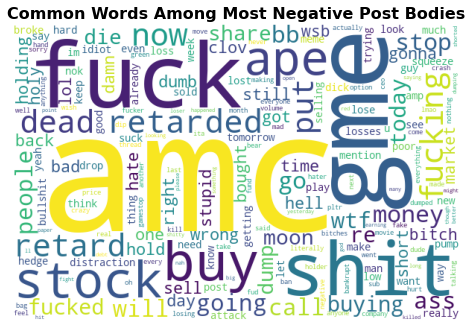

In [35]:
Most_Positive = body_data[body_data['Positive Sentiment'].between(0.4,1)]['body']
Most_Negative = body_data[body_data['Negative Sentiment'].between(0.25,1)]['body']

Most_Positive_text = ' '.join(Most_Positive)
Most_Negative_text = ' '.join(Most_Negative)


pwc = WordCloud(width=600,height=400,collocations = False,background_color='white').generate(Most_Positive_text)
nwc = WordCloud(width=600,height=400,collocations = False,background_color='white').generate(Most_Negative_text)

fig, ax = plt.subplots(figsize=(8,8))
plt.title('Common Words Among Most Positive Post Bodies',fontsize=16,fontweight='bold')
plt.imshow(pwc)
plt.axis('off')
fig, ax = plt.subplots(figsize=(8,8))
plt.title('Common Words Among Most Negative Post Bodies',fontsize=16,fontweight='bold')
plt.imshow(nwc)
plt.axis('off')

plt.show()

## Modeling

Modeling is in a seperate notebook titled "AMC_modeling".
In that notebook, first I will assume the accuracy of the VADER-generated 'body_sentiment' column. I will treat the column as my target. Next, I will try and predict the sentiment of 'cleaned_body' against the target. Some of the classification techniques I will be using include NaiveBayes, RandomForest, DecisionTree, and XGBoost. I will be submitting one of those as my FSM.